In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Hyperparameters
BATCH_SIZE  = 1
TARGET_SIZE = (224, 224)
EPOCHS      = 50  # adjust as needed


In [ ]:
import os, glob
import numpy as np

# point these at your two folders
INPUT_DIR  = '/content/drive/MyDrive/datasets/dataset_train/inputs'
OUTPUT_DIR = '/content/drive/MyDrive/datasets/dataset_train/target'

def load_npy_from_dir(dir_path):
    # grab all .npy files (non-recursive); adjust pattern if you have subfolders
    pattern = os.path.join(dir_path, '*.npy')
    files = sorted(glob.glob(pattern))
    if not files:
        raise ValueError(f"No .npy files found in {dir_path}")
    # load & stack into (N, …) array
    return np.stack([np.load(f).astype('float32') for f in files], axis=0)

# usage
power_maps = load_npy_from_dir(INPUT_DIR)
temp_maps  = load_npy_from_dir(OUTPUT_DIR)

# if they differ in count, trim to the smaller one
n = min(power_maps.shape[0], temp_maps.shape[0])
power_maps = power_maps[:n]
temp_maps  = temp_maps[:n]

print("Loaded shapes:", power_maps.shape, temp_maps.shape)


Loaded shapes: (6066, 224, 224, 5) (6066, 224, 224, 3)


In [ ]:
# Slice channel 0 → shape becomes (N,224,224,1)
X = power_maps[..., 0:1]
Y = temp_maps[..., 0:1]

print("power_maps shape before creating dataset:", X.shape)
print("temp_maps shape before creating dataset:", Y.shape)

# 80% train / 20% test split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

print(f"Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

power_maps shape before creating dataset: (6066, 224, 224, 1)
temp_maps shape before creating dataset: (6066, 224, 224, 1)
Train samples: 4852, Test samples: 1214


In [ ]:
def make_ds(X, Y, batch_size=BATCH_SIZE, target_size=TARGET_SIZE):
    ds = tf.data.Dataset.from_tensor_slices((X, Y))
    ds = ds.map(
        lambda x, y: (
            tf.image.resize(x, target_size),
            tf.image.resize(y, target_size)
        ),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_ds = make_ds(X_train, Y_train)
test_ds  = make_ds(X_test,  Y_test)

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model

def build_unet(input_shape=(224,224,1)):
    inputs = Input(shape=input_shape)
    # Encoder
    c1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D()(c2)

    # Bottleneck
    c5 = Conv2D(512, 3, activation='relu', padding='same')(p2)
    c5 = Conv2D(512, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = Conv2DTranspose(256, 2, strides=2, padding='same')(c5)
    merge6 = Concatenate()([u6, c2])
    c6 = Conv2D(256, 3, activation='relu', padding='same')(merge6)
    c6 = Conv2D(256, 3, activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(128, 2, strides=2, padding='same')(c6)
    merge7 = Concatenate()([u7, c1])
    c7 = Conv2D(128, 3, activation='relu', padding='same')(merge7)
    c7 = Conv2D(128, 3, activation='relu', padding='same')(c7)

    outputs = Conv2D(1, 1, activation='linear')(c7)
    return Model(inputs, outputs)

model = build_unet(input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 1))
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │    590,336 │ max_pooling2d_1[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │  2,359,808 │ conv2d_4[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 112, 112,  │    524,544 │ conv2d_5[0][0]    │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 112, 112,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 384)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 112, 112,  │    884,992 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 112, 112,  │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 224, 224,  │    131,200 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 224, 224,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 192)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 224, 224,  │    221,312 │ concatenate_1[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 224, 224,  │    147,584 │ conv2d_8[0][0]  

 Total params: 5,708,993 (21.78 MB)

 Trainable params: 5,708,993 (21.78 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[tf.keras.metrics.MeanAbsoluteError(name='mae')]
)

In [ ]:
import os
ckpt_dir = '/content/drive/MyDrive/TM_checkpoints'
os.makedirs(ckpt_dir, exist_ok=True)
ckpt_path = os.path.join(ckpt_dir, 'best_model.h5')

# 3) Callback to save only the best model (by val_mae)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckpt_path,
    monitor='val_mae',
    mode='min',
    save_best_only=True,
    verbose=1
)

import time
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []
    def on_epoch_begin(self, epoch, logs=None):
        self._start_time = time.time()
    def on_epoch_end(self, epoch, logs=None):
        duration = time.time() - self._start_time
        self.epoch_times.append(duration)
        thru = X_train.shape[0] / duration
        print(f"→ Epoch {epoch:02d} took {duration:.2f}s, throughput {thru:.1f} samples/s")

time_cb = TimeHistory()

In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=test_ds,
    callbacks=[checkpoint_cb, time_cb]
)


Epoch 1/50
4852/4852 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 171.5828 - mae: 8.0344
Epoch 1: val_mae improved from inf to 4.53674, saving model to /content/drive/MyDrive/TM_checkpoints/best_model.h5


→ Epoch 00 took 61.24s, throughput 79.2 samples/s
4852/4852 ━━━━━━━━━━━━━━━━━━━━ 61s 10ms/step - loss: 171.5612 - mae: 8.0340 - val_loss: 34.6873 - val_mae: 4.5367
Epoch 2/50
4847/4852 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 36.4037 - mae: 4.6915
Epoch 2: val_mae did not improve from 4.53674
→ Epoch 01 took 46.40s, throughput 104.6 samples/s
4852/4852 ━━━━━━━━━━━━━━━━━━━━ 46s 10ms/step - loss: 36.4033 - mae: 4.6915 - val_loss: 39.3290 - val_mae: 4.9786
Epoch 3/50
4849/4852 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 33.2590 - mae: 4.4538
Epoch 3: val_mae improved from 4.53674 to 4.45062, saving model to /content/drive/MyDrive/TM_checkpoints/best_model.h5


→ Epoch 02 took 47.07s, throughput 103.1 samples/s
4852/4852 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - loss: 33.2582 - mae: 4.4537 - val_loss: 33.5120 - val_mae: 4.4506
Epoch 4/50
4849/4852 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 31.0083 - mae: 4.2613
Epoch 4: val_mae improved from 4.45062 to 4.22416, saving model to /content/drive/MyDrive/TM_checkpoints/best_model.h5


→ Epoch 03 took 47.18s, throughput 102.9 samples/s
4852/4852 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - loss: 31.0075 - mae: 4.2613 - val_loss: 30.5534 - val_mae: 4.2242
Epoch 5/50
4849/4852 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 29.2470 - mae: 4.1039
Epoch 5: val_mae improved from 4.22416 to 4.21381, saving model to /content/drive/MyDrive/TM_checkpoints/best_model.h5


→ Epoch 04 took 47.07s, throughput 103.1 samples/s
4852/4852 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - loss: 29.2464 - mae: 4.1038 - val_loss: 30.3359 - val_mae: 4.2138
Epoch 6/50
4849/4852 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 28.0350 - mae: 3.9861
Epoch 6: val_mae improved from 4.21381 to 4.07757, saving model to /content/drive/MyDrive/TM_checkpoints/best_model.h5


→ Epoch 05 took 47.10s, throughput 103.0 samples/s
4852/4852 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - loss: 28.0345 - mae: 3.9861 - val_loss: 29.5918 - val_mae: 4.0776
Epoch 7/50
4849/4852 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 27.0942 - mae: 3.8918
Epoch 7: val_mae improved from 4.07757 to 3.97433, saving model to /content/drive/MyDrive/TM_checkpoints/best_model.h5


→ Epoch 06 took 47.11s, throughput 103.0 samples/s
4852/4852 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - loss: 27.0937 - mae: 3.8918 - val_loss: 28.6848 - val_mae: 3.9743
Epoch 8/50
4849/4852 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 26.6603 - mae: 3.8469
Epoch 8: val_mae improved from 3.97433 to 3.96842, saving model to /content/drive/MyDrive/TM_checkpoints/best_model.h5


→ Epoch 07 took 47.20s, throughput 102.8 samples/s
4852/4852 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - loss: 26.6598 - mae: 3.8468 - val_loss: 27.9966 - val_mae: 3.9684
Epoch 9/50
4849/4852 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 26.1604 - mae: 3.7967
Epoch 9: val_mae improved from 3.96842 to 3.84925, saving model to /content/drive/MyDrive/TM_checkpoints/best_model.h5


→ Epoch 08 took 47.11s, throughput 103.0 samples/s
4852/4852 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - loss: 26.1600 - mae: 3.7967 - val_loss: 27.2352 - val_mae: 3.8492
Epoch 10/50
4849/4852 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 25.8188 - mae: 3.7587
Epoch 10: val_mae improved from 3.84925 to 3.72858, saving model to /content/drive/MyDrive/TM_checkpoints/best_model.h5


→ Epoch 09 took 47.08s, throughput 103.1 samples/s
4852/4852 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - loss: 25.8184 - mae: 3.7587 - val_loss: 25.7724 - val_mae: 3.7286
Epoch 11/50
4849/4852 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 25.5480 - mae: 3.7302
Epoch 11: val_mae improved from 3.72858 to 3.70012, saving model to /content/drive/MyDrive/TM_checkpoints/best_model.h5


→ Epoch 10 took 47.25s, throughput 102.7 samples/s
4852/4852 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - loss: 25.5476 - mae: 3.7302 - val_loss: 25.4986 - val_mae: 3.7001
Epoch 12/50
4849/4852 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 25.1845 - mae: 3.6906
Epoch 12: val_mae improved from 3.70012 to 3.68173, saving model to /content/drive/MyDrive/TM_checkpoints/best_model.h5


→ Epoch 11 took 47.15s, throughput 102.9 samples/s
4852/4852 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - loss: 25.1841 - mae: 3.6906 - val_loss: 25.3296 - val_mae: 3.6817
Epoch 13/50
4849/4852 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 24.9967 - mae: 3.6696
Epoch 13: val_mae improved from 3.68173 to 3.60379, saving model to /content/drive/MyDrive/TM_checkpoints/best_model.h5


→ Epoch 12 took 47.36s, throughput 102.4 samples/s
4852/4852 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - loss: 24.9963 - mae: 3.6695 - val_loss: 24.6674 - val_mae: 3.6038
Epoch 14/50
4849/4852 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 24.8581 - mae: 3.6535
Epoch 14: val_mae improved from 3.60379 to 3.57662, saving model to /content/drive/MyDrive/TM_checkpoints/best_model.h5


→ Epoch 13 took 47.31s, throughput 102.6 samples/s
4852/4852 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - loss: 24.8576 - mae: 3.6534 - val_loss: 24.4475 - val_mae: 3.5766
Epoch 15/50
4849/4852 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 24.6684 - mae: 3.6336
Epoch 15: val_mae improved from 3.57662 to 3.54218, saving model to /content/drive/MyDrive/TM_checkpoints/best_model.h5


→ Epoch 14 took 47.36s, throughput 102.4 samples/s
4852/4852 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - loss: 24.6680 - mae: 3.6336 - val_loss: 24.2015 - val_mae: 3.5422
Epoch 16/50
4849/4852 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 25.2488 - mae: 3.6829
Epoch 16: val_mae did not improve from 3.54218
→ Epoch 15 took 46.29s, throughput 104.8 samples/s
4852/4852 ━━━━━━━━━━━━━━━━━━━━ 46s 10ms/step - loss: 25.2482 - mae: 3.6828 - val_loss: 24.6020 - val_mae: 3.5786
Epoch 17/50
4849/4852 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 24.4929 - mae: 3.6111
Epoch 17: val_mae did not improve from 3.54218
→ Epoch 16 took 46.55s, throughput 104.2 samples/s
4852/4852 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - loss: 24.4925 - mae: 3.6111 - val_loss: 24.3267 - val_mae: 3.5607
Epoch 18/50
4849/4852 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 24.3463 - mae: 3.5978
Epoch 18: val_mae improved from 3.54218 to 3.51791, saving model to /content/drive/MyDrive/TM_checkpoints/best_model.h5


→ Epoch 17 took 48.79s, throughput 99.5 samples/s
4852/4852 ━━━━━━━━━━━━━━━━━━━━ 49s 10ms/step - loss: 24.3459 - mae: 3.5978 - val_loss: 23.9541 - val_mae: 3.5179
Epoch 19/50
4851/4852 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 24.1822 - mae: 3.5796
Epoch 19: val_mae improved from 3.51791 to 3.50653, saving model to /content/drive/MyDrive/TM_checkpoints/best_model.h5


→ Epoch 18 took 47.25s, throughput 102.7 samples/s
4852/4852 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - loss: 24.1820 - mae: 3.5796 - val_loss: 23.9189 - val_mae: 3.5065
Epoch 20/50
4849/4852 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 24.0026 - mae: 3.5593
Epoch 20: val_mae improved from 3.50653 to 3.47741, saving model to /content/drive/MyDrive/TM_checkpoints/best_model.h5


→ Epoch 19 took 47.54s, throughput 102.1 samples/s
4852/4852 ━━━━━━━━━━━━━━━━━━━━ 48s 10ms/step - loss: 24.0022 - mae: 3.5593 - val_loss: 23.6745 - val_mae: 3.4774
Epoch 21/50
4849/4852 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 23.9216 - mae: 3.5506
Epoch 21: val_mae did not improve from 3.47741
→ Epoch 20 took 46.56s, throughput 104.2 samples/s
4852/4852 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - loss: 23.9212 - mae: 3.5505 - val_loss: 23.7853 - val_mae: 3.4950
Epoch 22/50
4849/4852 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 23.8866 - mae: 3.5463
Epoch 22: val_mae did not improve from 3.47741
→ Epoch 21 took 46.58s, throughput 104.2 samples/s
4852/4852 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - loss: 23.8862 - mae: 3.5463 - val_loss: 24.2376 - val_mae: 3.5297
Epoch 23/50
4849/4852 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 23.8421 - mae: 3.5417
Epoch 23: val_mae improved from 3.47741 to 3.45544, saving model to /content/drive/MyDrive/TM_checkpoints/best_model.h5


→ Epoch 22 took 47.79s, throughput 101.5 samples/s
4852/4852 ━━━━━━━━━━━━━━━━━━━━ 48s 10ms/step - loss: 23.8416 - mae: 3.5417 - val_loss: 23.5199 - val_mae: 3.4554
Epoch 24/50
4849/4852 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 23.7370 - mae: 3.5311
Epoch 24: val_mae did not improve from 3.45544
→ Epoch 23 took 46.34s, throughput 104.7 samples/s
4852/4852 ━━━━━━━━━━━━━━━━━━━━ 46s 10ms/step - loss: 23.7366 - mae: 3.5311 - val_loss: 23.5495 - val_mae: 3.4681
Epoch 25/50
4849/4852 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 23.6966 - mae: 3.5248
Epoch 25: val_mae did not improve from 3.45544
→ Epoch 24 took 46.31s, throughput 104.8 samples/s
4852/4852 ━━━━━━━━━━━━━━━━━━━━ 46s 10ms/step - loss: 23.6963 - mae: 3.5248 - val_loss: 23.6944 - val_mae: 3.4759
Epoch 26/50
4849/4852 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 23.4878 - mae: 3.5003
Epoch 26: val_mae did not improve from 3.45544
→ Epoch 25 took 46.32s, throughput 104.8 samples/s
4852/4852 ━━━━━━━━━━━━━━━━━━━━ 46s 10ms/step - loss: 23.4875 

→ Epoch 26 took 47.65s, throughput 101.8 samples/s
4852/4852 ━━━━━━━━━━━━━━━━━━━━ 48s 10ms/step - loss: 23.5202 - mae: 3.5047 - val_loss: 23.3826 - val_mae: 3.4413
Epoch 28/50
4849/4852 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 23.3948 - mae: 3.4916
Epoch 28: val_mae improved from 3.44126 to 3.43601, saving model to /content/drive/MyDrive/TM_checkpoints/best_model.h5


→ Epoch 27 took 47.91s, throughput 101.3 samples/s
4852/4852 ━━━━━━━━━━━━━━━━━━━━ 48s 10ms/step - loss: 23.3945 - mae: 3.4915 - val_loss: 23.3614 - val_mae: 3.4360
Epoch 29/50
4849/4852 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 23.3605 - mae: 3.4877
Epoch 29: val_mae did not improve from 3.43601
→ Epoch 28 took 46.59s, throughput 104.1 samples/s
4852/4852 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - loss: 23.3601 - mae: 3.4876 - val_loss: 23.3921 - val_mae: 3.4420
Epoch 30/50
4849/4852 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 23.3319 - mae: 3.4838
Epoch 30: val_mae did not improve from 3.43601
→ Epoch 29 took 46.66s, throughput 104.0 samples/s
4852/4852 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - loss: 23.3315 - mae: 3.4838 - val_loss: 23.4229 - val_mae: 3.4466
Epoch 31/50
4849/4852 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 23.2919 - mae: 3.4807
Epoch 31: val_mae did not improve from 3.43601
→ Epoch 30 took 46.60s, throughput 104.1 samples/s
4852/4852 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - loss: 23.2916 

→ Epoch 36 took 47.51s, throughput 102.1 samples/s
4852/4852 ━━━━━━━━━━━━━━━━━━━━ 48s 10ms/step - loss: 23.1342 - mae: 3.4580 - val_loss: 23.3183 - val_mae: 3.4326
Epoch 38/50
4849/4852 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 23.0372 - mae: 3.4492
Epoch 38: val_mae did not improve from 3.43261
→ Epoch 37 took 46.48s, throughput 104.4 samples/s
4852/4852 ━━━━━━━━━━━━━━━━━━━━ 46s 10ms/step - loss: 23.0369 - mae: 3.4492 - val_loss: 23.4840 - val_mae: 3.4520
Epoch 39/50
4849/4852 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 23.0344 - mae: 3.4489
Epoch 39: val_mae did not improve from 3.43261
→ Epoch 38 took 46.43s, throughput 104.5 samples/s
4852/4852 ━━━━━━━━━━━━━━━━━━━━ 46s 10ms/step - loss: 23.0340 - mae: 3.4489 - val_loss: 23.6425 - val_mae: 3.4659
Epoch 40/50
4849/4852 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 22.9883 - mae: 3.4432
Epoch 40: val_mae did not improve from 3.43261
→ Epoch 39 took 46.57s, throughput 104.2 samples/s
4852/4852 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - loss: 22.9880 

In [ ]:
loss, mae = model.evaluate(test_ds)
print(f"Test loss (MSE): {loss:.4f}")
print(f"Test MAE   : {mae:.4f}")


1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 23.8068 - mae: 3.4800
Test loss (MSE): 24.2777
Test MAE   : 3.5053


In [ ]:
import numpy as np

# 1) get raw predictions and ground-truth from the test set
y_pred = model.predict(test_ds)
y_true = np.concatenate([y for _, y in test_ds], axis=0)

# 2) compute mean absolute error in °C
abs_loss = np.mean(np.abs(y_pred - y_true))
print(f"Mean Absolute Error: {abs_loss:.4f} °C")


1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Mean Absolute Error: 3.5053 °C


In [ ]:
import time

# a) Warm-up
for x_batch, _ in test_ds.take(1):
    _ = model.predict(x_batch)

# b) Measure over the entire test set
start = time.time()
n = 0
for x_batch, _ in test_ds:
    n += x_batch.shape[0]
    _ = model.predict(x_batch)
elapsed = time.time() - start

throughput = n / elapsed
latency_ms = elapsed / n * 1000

print(f"Test set: {n} samples in {elapsed:.2f}s")
print(f"→ Throughput: {throughput:.2f} samples/s")
print(f"→ Avg latency: {latency_ms:.2f} ms/sample")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━

In [ ]:
# A quick rule-of-thumb: ~2 × total trainable parameters
total_params = model.count_params()
flops_approx = 2 * total_params
print(f"Approximate FLOPs per inference: {flops_approx:,}")

Approximate FLOPs per inference: 11,417,986


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


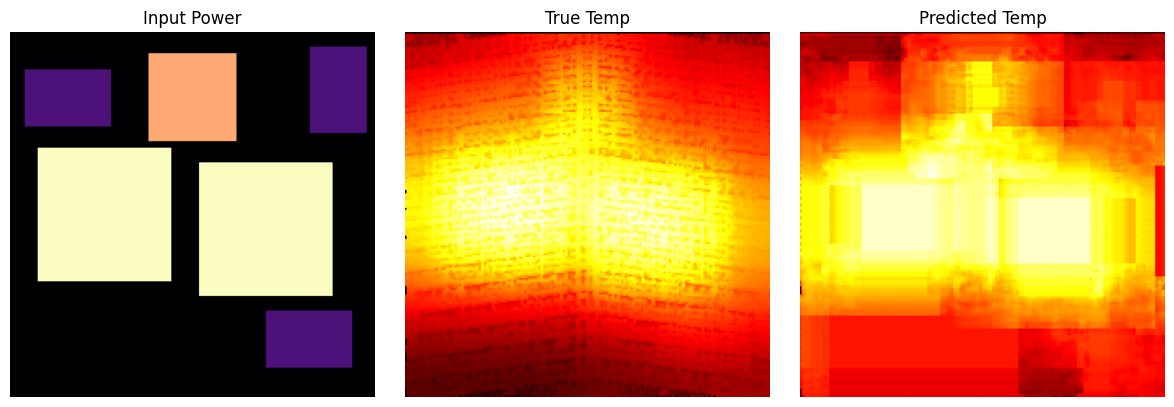

In [ ]:
import matplotlib.pyplot as plt

# Take one batch from the test dataset and plot input, truth, and prediction
for x_batch, y_batch in test_ds.take(1):
    # Run the model to get the prediction
    y_pred_batch = model.predict(x_batch)

    # Extract the single sample and its single channel
    input_power = x_batch[0, ..., 0]
    true_temp   = y_batch[0, ..., 0]
    pred_temp   = y_pred_batch[0, ..., 0]

    # Plot side-by-side
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    for ax, img, title in zip(
        axes,
        [input_power, true_temp, pred_temp],
        ['Input Power', 'True Temp', 'Predicted Temp']
    ):
        ax.imshow(img, cmap='magma' if 'Power' in title else 'hot')
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    break


Test set shapes —  x: (150, 224, 224, 1),  y: (150, 224, 224, 1)
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 28.8015 - mae: 3.8589
Test loss / metrics: [26.506067276000977, 3.6905338764190674]
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


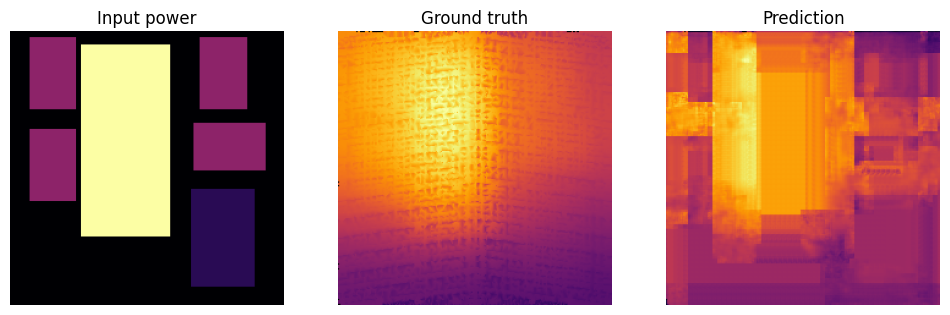

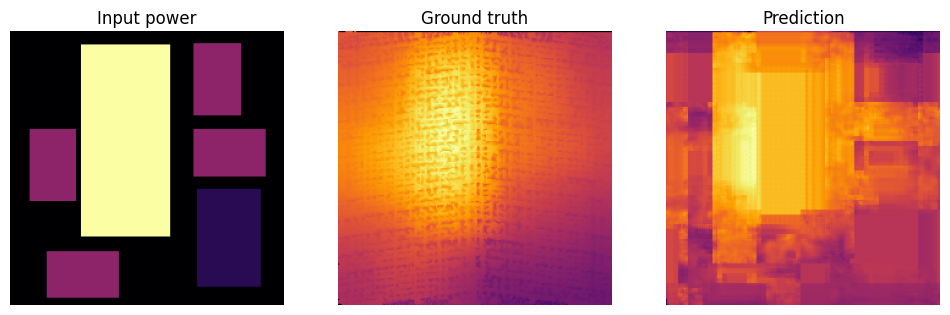

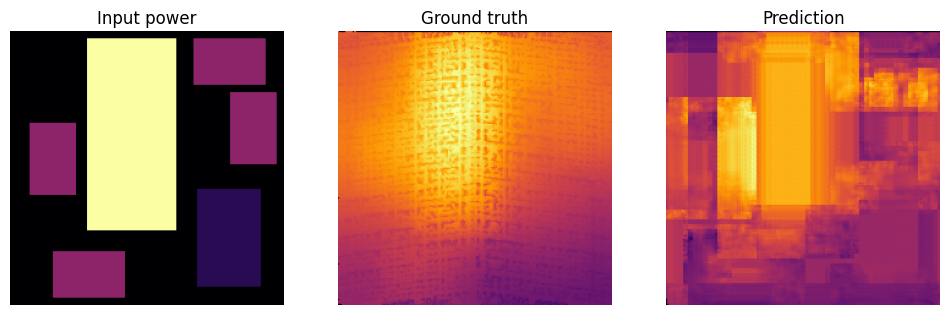

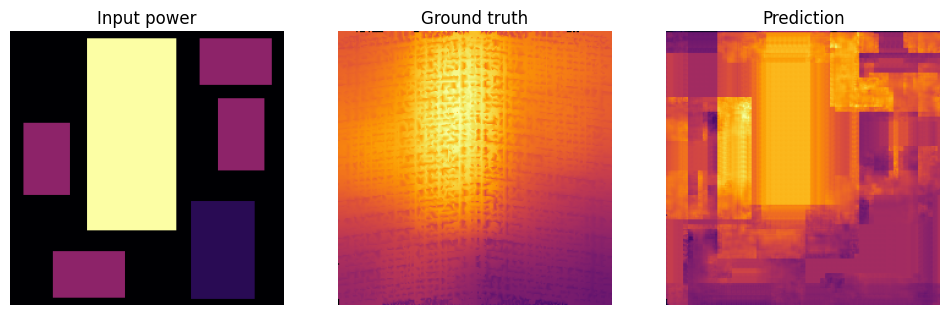

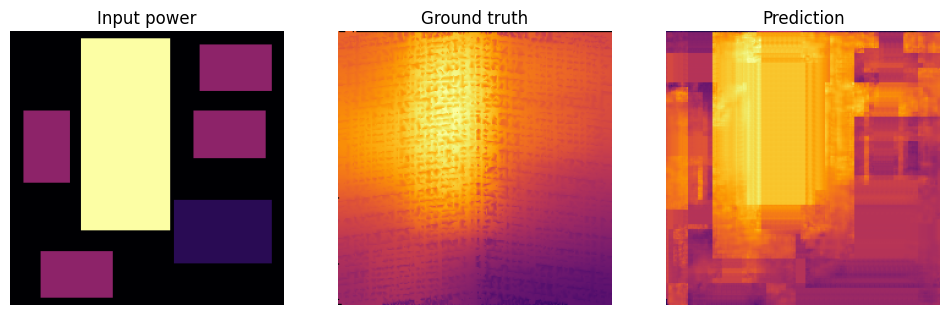

In [ ]:
# --- adjust these paths to your test folders ---
TEST_INPUT_DIR  = '/content/drive/MyDrive/datasets/dataset_test/inputs'
TEST_TARGET_DIR = '/content/drive/MyDrive/datasets/dataset_test/targets'

# reuse your directory-loading helper (or re-define it here)
import os, glob
import numpy as np

def load_npy_from_dir(dir_path, recursive=False):
    pattern = os.path.join(dir_path, '**', '*.npy') if recursive else os.path.join(dir_path, '*.npy')
    files = sorted(glob.glob(pattern, recursive=recursive))
    if not files:
        raise ValueError(f"No .npy files found in {dir_path}")
    return np.stack([np.load(f).astype('float32') for f in files], axis=0)

# load test arrays
x_test = load_npy_from_dir(TEST_INPUT_DIR, recursive=True)   # set recursive=True if you have sub-folders
y_test = load_npy_from_dir(TEST_TARGET_DIR, recursive=True)

x_test = x_test[..., 0:1]
y_test = y_test[..., 0:1]


# trim in case counts differ
n = min(len(x_test), len(y_test))
x_test, y_test = x_test[:n], y_test[:n]

print(f"Test set shapes —  x: {x_test.shape},  y: {y_test.shape}")

# --- Evaluate the model on the full test set ---
# assumes your UNet model is called `model`
results = model.evaluate(x_test, y_test, batch_size=4)     # tweak batch_size as needed
print("Test loss / metrics:", results)

# --- (Optional) Run per‐sample inference and visualize a few results ---
import matplotlib.pyplot as plt

preds = model.predict(x_test, batch_size=4)
for i in range(min(5, n)):
    fig, axes = plt.subplots(1,3, figsize=(12,4))
    axes[0].imshow(x_test[i,...,0],  cmap='inferno')
    axes[0].set_title("Input power")
    axes[1].imshow(y_test[i,...,0], cmap='inferno')
    axes[1].set_title("Ground truth")
    axes[2].imshow(preds[i,...,0], cmap='inferno')
    axes[2].set_title("Prediction")
    for ax in axes: ax.axis('off')
    plt.show()


In [36]:
import os
import glob
import numpy as np
from collections import defaultdict

# ─── MOUNTED DRIVE PATH ────────────────────────────────────────────────────────
drive_root   = "/content/drive/MyDrive"
results_root = os.path.join(drive_root, "AI_Temperature", "RESULTS_DAC")
gt_save_dir   = os.path.join(results_root, "gt")
pred_save_dir = os.path.join(results_root, "pred")
os.makedirs(gt_save_dir,   exist_ok=True)
os.makedirs(pred_save_dir, exist_ok=True)

# ─── USER CONFIG ───────────────────────────────────────────────────────────────
# (assumes `model` is already built & loaded above)
inp_dir    = "/content/drive/MyDrive/datasets/dataset_test/inputs"
gt_dir     = "/content/drive/MyDrive/datasets/dataset_test/targets"
heat_value = 950.0
prefixes   = ['multi_gpu', 'ascend910', 'micro150']
# ────────────────────────────────────────────────────────────────────────────────

results = defaultdict(lambda: {'mae': [], 'rmse': [], 'r2': []})

def eval_sample_keras(model, inp_np, gt_np, heat_value):
    # Use only the first channel of the input as the model expects a single channel
    inp = inp_np[..., 0:1].astype(np.float32)

    x    = np.expand_dims(inp, axis=0)                  # shape (1, H, W, 1)
    pred = model.predict(x)[0,...]                     # shape (H, W) or (H, W, 1)
    if pred.ndim == 3 and pred.shape[-1] == 1:
        pred = pred[...,0]

    gt = gt_np.astype(np.float32)
    if gt.ndim == 3 and gt.shape[-1] == 1:
        gt = gt[...,0]
    # Also use only the first channel of the ground truth
    gt = gt_np[..., 0].astype(np.float32)


    mae   = np.mean(np.abs(pred - gt))
    rmse  = np.sqrt(np.mean((pred - gt)**2))
    ss_res= np.sum((pred - gt)**2)
    ss_tot= np.sum((gt   - gt.mean())**2)
    r2    = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan

    return pred, gt, mae, rmse, r2

# ─── EVALUATION LOOP ────────────────────────────────────────────────────────────
for inp_path in sorted(glob.glob(os.path.join(inp_dir, "*.npy"))):
    base = os.path.basename(inp_path)[:-4]
    prefix = next((p for p in prefixes if base.startswith(p)), None)
    if prefix is None:
        continue

    # swap "_inp" → "_out" to match your GT filenames
    gt_filename = base.replace("_inp", "_out") + ".npy"
    gt_path     = os.path.join(gt_dir, gt_filename)
    if not os.path.exists(gt_path):
        print(f"⚠️ missing GT for {base} (looking for {gt_filename})")
        continue

    inp_np = np.load(inp_path)
    gt_np  = np.load(gt_path)
    pred, gt, mae, rmse, r2 = eval_sample_keras(model, inp_np, gt_np, heat_value)

    # save to Drive
    np.save(os.path.join(gt_save_dir,   gt_filename), gt)
    pred_filename = base.replace("_inp", "_pred") + ".npy"
    np.save(os.path.join(pred_save_dir, pred_filename), pred)

    results[prefix]['mae'].append(mae)
    results[prefix]['rmse'].append(rmse)
    results[prefix]['r2'].append(r2)

# ─── PRINT RESULTS ──────────────────────────────────────────────────────────────
print("\n=== Average metrics by prefix ===")
for p in prefixes:
    if results[p]['mae']:
        print(f"{p:12s} | MAE: {np.mean(results[p]['mae']):.4f}  "
              f"RMSE: {np.mean(results[p]['rmse']):.4f}  "
              f"R²: {np.mean(results[p]['r2']):.4f}")
    else:
        print(f"{p:12s} | no samples found")

all_mae  = np.hstack([results[p]['mae']  for p in prefixes if results[p]['mae']])
all_rmse = np.hstack([results[p]['rmse'] for p in prefixes if results[p]['rmse']])
all_r2   = np.hstack([results[p]['r2']   for p in prefixes if results[p]['r2']])
print(f"\nOverall   | MAE: {all_mae.mean():.4f}  "
      f"RMSE: {all_rmse.mean():.4f}  "
      f"R²: {all_r2.mean():.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━